<a href="https://colab.research.google.com/github/nas-tishenkova/Homework/blob/mainbranch/dz5_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Вытащим дс из кеггла в колаб 
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import json
token = {"username":"resonansss","key":"aea7746cc9e4244102f6bc268fcaa9e7"}
with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

In [28]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [29]:
!chmod 600 /root/.kaggle/kaggle.json

In [30]:
!kaggle datasets list -s fare

ref                                                  title                                   size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -------------------------------------  -----  -------------------  -------------  ---------  ---------------  
yasserh/uber-fares-dataset                           Uber Fares Dataset                       7MB  2022-01-01 15:54:14          12044         88  1.0              
mpwolke/cusersmarildownloadscompliancecsv            Fare Compliance                         85KB  2019-09-07 12:01:58             80         27  1.0              
yashdharme36/airfare-ml-predicting-flight-fares      Airfare ML : Predicting Flight Fares     7MB  2023-03-16 16:44:29           1226         30  1.0              
zwartfreak/airline-fare-prediction                   Airline fare prediction                627KB  2022-01-18 12:42:13            992         27  0.7647059        
nikhilmittal/fli

In [31]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction -p /content

100% 1.56G/1.56G [00:45<00:00, 41.8MB/s]
100% 1.56G/1.56G [00:45<00:00, 36.8MB/s]


In [32]:
!unzip \*.zip

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 

In [35]:
data = pd.read_csv('/content/train.csv',nrows=1000000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [37]:
data = data.dropna()

координаты нью-йорка:
Широта: 40°42′51″ с.ш.
Долгота: 74°00′21″ з.д.

In [38]:
#функция для правки характеристик дс
def popravit(data):
  data = data[
    #(data['fare_amount'] > 0.) & #удаляем строки где стоимость поездки отрицательная 
    #(data['fare_amount'] <= 1000.) & #удаляем строки где стоимость поездки чересчур завышенная
    (data['pickup_longitude'] >= -75) & #удаляем строки с координатами, не относящихся к нй
    (data['pickup_longitude'] <= -71) &
    (data['pickup_latitude'] >= 40) &
    (data['pickup_latitude'] <= 43) &
    (data['dropoff_longitude'] >= -75) &
    (data['dropoff_longitude'] <= -71) &
    (data['dropoff_latitude'] >= 40) &
    (data['dropoff_latitude'] <= 43) &
    (data['passenger_count'] > 0) & #удаляем строки с отрицательным кол-вом пассажиров
    (data['passenger_count'] < 6) #удаляем строки с большим кол-вом пассажиров
 ]
popravit(data)

In [39]:
#функции для праздников и выходных
def isaholiday(data):
  data[['Date','Time']] = data.key.str.split(expand=True)#поделила колонку key на дату и время
  data['Date'] = pd.to_datetime(data['Date'])
  cal = calendar()
  holidays = cal.holidays(start=data['Date'].min(), end=data['Date'].max())
  data['holiday'] = data['Date'].dt.date.astype('datetime64').isin(holidays)
  data['holiday'] = data.apply(lambda x : 0 if x['holiday'] == False else 1, axis = 1)
isaholiday(data)

def isaweekend(data):
  temp = pd.DatetimeIndex(data['Date'])
  data['weekday'] = temp.weekday
  data['weekday'] = data.apply(lambda x : 0 if x['weekday'] <= 4 else 1, axis = 1)#если что,0 - это понедельник,1 - вторник и т.д.
isaweekend(data)


Расстояние между двумя параллелями (фактически — дуга меридиана), которые отличаются на 1° по широте, — примерно 111 км. Длина градуса долготы вдоль экватора составляет ровно 60 географических миль, или 111,3 километра.

In [40]:
#создаем колонку с евклидовым расстоянием
def euclidean_dist(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    latitude_to_km = 111 #один градус широты в км
    longitude_to_km = 111.3 #один градус долготы в км
    distance = np.sqrt(((dropoff_latitude - pickup_latitude) * latitude_to_km) ** 2 + ((dropoff_longitude - pickup_longitude) * longitude_to_km) ** 2)
    return distance

data['euclidean_distance'] = data.apply(lambda row :
                                            euclidean_dist(row['pickup_latitude'],
                                                row['pickup_longitude'],
                                                row['dropoff_latitude'],
                                                row['dropoff_longitude'],), axis = 1)

#колонка с манхэттенским расстоянием
def manhattan_dist(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    latitude_to_km = 111 #один градус широты в км
    longitude_to_km = 111.3 #один градус долготы в км
    distance = abs((dropoff_latitude - pickup_latitude) * latitude_to_km) + abs((dropoff_longitude - pickup_longitude) * longitude_to_km)
    return distance

data['manhattan_distance'] = data.apply(lambda row :
                                            manhattan_dist(row['pickup_latitude'],
                                                row['pickup_longitude'],
                                                row['dropoff_latitude'],
                                                row['dropoff_longitude'],), axis = 1)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954894 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   key                 954894 non-null  object        
 1   fare_amount         954894 non-null  float64       
 2   pickup_datetime     954894 non-null  object        
 3   pickup_longitude    954894 non-null  float64       
 4   pickup_latitude     954894 non-null  float64       
 5   dropoff_longitude   954894 non-null  float64       
 6   dropoff_latitude    954894 non-null  float64       
 7   passenger_count     954894 non-null  int64         
 8   Date                954894 non-null  datetime64[ns]
 9   Time                954894 non-null  object        
 10  holiday             954894 non-null  int64         
 11  weekday             954894 non-null  int64         
 12  euclidean_distance  954894 non-null  float64       
 13  manhattan_distance  954894 no

In [43]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Date,Time,holiday,weekday,euclidean_distance,manhattan_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21.0000001,0,0,1.047611,1.304172
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16.0000002,0,0,8.851317,11.941425
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00.00000049,0,0,1.519406,2.135083
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42.0000001,0,1,2.813026,3.263177
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00.000000135,0,0,2.163135,3.021966


In [ ]:
#по приколу смотрим координаты начала и конца поездки (тут 10 первых вхождений), это можно не запускать


import folium

%matplotlib inline
plt.style.use('seaborn-whitegrid')


map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

pickups = []
dropoffs = []
for index, row in data.iterrows():
    pickup = [row["pickup_latitude"], row["pickup_longitude"]]
    dropoff = [row["dropoff_latitude"], row["dropoff_longitude"]]
    pickups.append(pickup)
    dropoffs.append(dropoff)

#Plotting pickups and dropoff    
for index, (pickup, dropoff) in enumerate(zip(pickups[:10], dropoffs[:10])):
    folium.Marker(
        location=pickup,
        popup="Pickup",
        icon=folium.Icon(color="blue"),
        ).add_to(map_nyc)
    folium.Marker(
        location=dropoff,
        popup="Dropoff",
        icon=folium.Icon(color="red"),
        ).add_to(map_nyc)
map_nyc

In [44]:
def divdate(data):
  data['Hour'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z').dt.hour
  data['Year'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z').dt.year
  data['Month'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z').dt.month
  data['Day'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z').dt.day
divdate(data)

In [45]:
#создадим доп данные, чтобы проверить зависимость от посадки/высадки у аэропорта

airports_nyc = {'JFK':{'min_long':-73.835,
                       'min_lat':40.619,
                       'max_long':-73.740, 
                       'max_lat':40.665},
                
                'EWR':{'min_long':-74.192,
                       'min_lat':40.670, 
                       'max_long':-74.153, 
                       'max_lat':40.708},
                
                'LAGUA':{'min_long':-73.889,
                         'min_lat':40.766, 
                         'max_long':-73.855,
                         'max_lat':40.793}
                }

def airp(latitude, longitude, airport_name):
  if (longitude >= airports_nyc[airport_name]['min_long'] and
      latitude >= airports_nyc[airport_name]['min_lat'] and
      longitude <= airports_nyc[airport_name]['max_long'] and
      longitude <= airports_nyc[airport_name]['max_long']):
    return 1
  else:
    return 0

data['pickup_JFK'] = data.apply(lambda row: airp(row['pickup_latitude'], row['pickup_longitude'], 'JFK'), axis=1)
data['dropoff_JFK'] = data.apply(lambda row: airp(row['dropoff_latitude'], row['dropoff_longitude'], 'JFK'), axis=1)
data['pickup_EWR'] = data.apply(lambda row: airp(row['pickup_latitude'], row['pickup_longitude'], 'EWR'), axis=1)
data['dropoff_EWR'] = data.apply(lambda row: airp(row['dropoff_latitude'], row['dropoff_longitude'], 'EWR'), axis=1)
data['pickup_LAGUA'] = data.apply(lambda row: airp(row['pickup_latitude'], row['pickup_longitude'], 'LAGUA'), axis=1)
data['dropoff_LAGUA'] = data.apply(lambda row: airp(row['dropoff_latitude'], row['dropoff_longitude'], 'LAGUA'), axis=1)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954894 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   key                 954894 non-null  object        
 1   fare_amount         954894 non-null  float64       
 2   pickup_longitude    954894 non-null  float64       
 3   pickup_latitude     954894 non-null  float64       
 4   dropoff_longitude   954894 non-null  float64       
 5   dropoff_latitude    954894 non-null  float64       
 6   passenger_count     954894 non-null  int64         
 7   Date                954894 non-null  datetime64[ns]
 8   Time                954894 non-null  object        
 9   holiday             954894 non-null  int64         
 10  weekday             954894 non-null  int64         
 11  euclidean_distance  954894 non-null  float64       
 12  manhattan_distance  954894 non-null  float64       
 13  Hour                954894 no

In [47]:
def drops(data)
  data.drop('pickup_datetime', axis=1, inplace=True)#это убираем, все данные в других столбиках - всё в числах
  data.drop(columns = 'Date', axis = 1 , inplace = True)
  data.drop(columns = 'Time', axis = 1 , inplace = True)
drops(data)

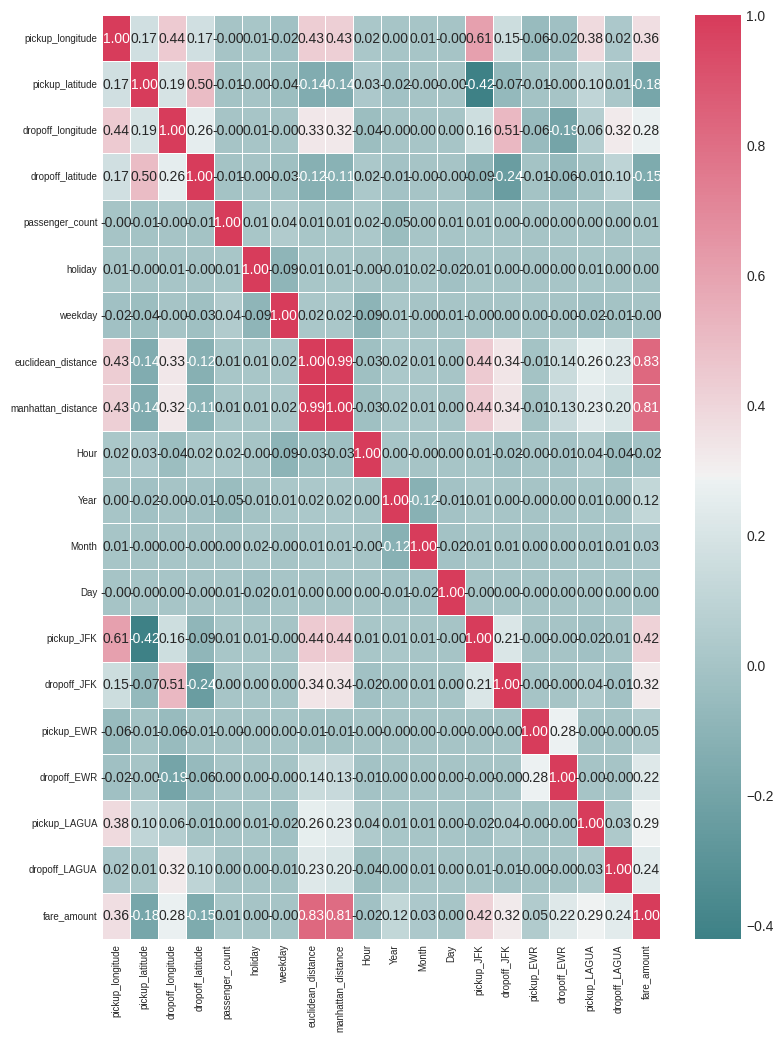

In [ ]:
#посмотрим потом зависимость всего от всего

data_1 = pd.DataFrame(data=np.c_[data.drop(columns = 'fare_amount', axis = 1), data['fare_amount']],
                     columns=list(data.drop(columns = 'fare_amount', axis = 1)) + ['fare_amount'])

plt.figure(figsize=(9,12))

corr = data_1.corr()

g = sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(200, 5,as_cmap=True))

g.set_xticklabels(g.get_xticklabels(), fontsize = 7)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 7)
plt.show()

In [50]:
data_corr = data.corr()

display(data_corr['fare_amount'].sort_values(ascending = False))

fare_amount           1.000000
euclidean_distance    0.825351
manhattan_distance    0.807196
pickup_JFK            0.415206
pickup_longitude      0.364782
dropoff_JFK           0.322234
pickup_LAGUA          0.285019
dropoff_longitude     0.277720
dropoff_LAGUA         0.239886
dropoff_EWR           0.224137
Year                  0.116876
pickup_EWR            0.045336
Month                 0.025690
passenger_count       0.007184
Day                   0.001528
holiday               0.000696
weekday              -0.002550
Hour                 -0.019472
dropoff_latitude     -0.154880
pickup_latitude      -0.184590
Name: fare_amount, dtype: float64

In [ ]:
#https://seaborn.pydata.org/generated/seaborn.pairplot.html
g = sns.pairplot(data_corr, kind = 'reg', diag_kind = 'kde', plot_kws = {'line_kws':{'color':'red', 'alpha': 0.7}})
g = g.map_offdiag(plt.scatter, alpha = 0.5, color = 'darkred')
g.fig.suptitle('Парные графики зависимости всего от всего', fontsize = 20)
plt.subplots_adjust(top = 0.95)

In [53]:
#вот на этом можно попробовать обучиться
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

#масштабирование
X = data.drop(['fare_amount', 'key'], axis=1)
y = data['fare_amount']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1)

#print("X_train Size ", Xtrain.shape)
#print("Y training size ", ytrain.shape)
#print("X validation size ", Xtest.shape)
#print("Y validation size ", ytest.shape)
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

regressor = LinearRegression()
regressor.fit(Xtrain, ytrain)

ypred_train = regressor.predict(Xtrain)
ypred_test = regressor.predict(Xtest)

print(r2_score(ytrain,ypred_train), r2_score(ytest,ypred_test))


coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
print(f'коэффициенты{coefficients}')


#лассо
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=17)
lasso_cv.fit(X, y)


regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred2_train), r2_score(ytest,ypred2_test))



model = LinearRegression()
print(cross_val_score(model, X, y, cv = 3, scoring = 'r2').mean())


#обучили с параметром регуляризации а
regressor2 = Lasso(alpha=lasso_cv.alpha_)

regressor2.fit(Xtrain, ytrain)

ypred2_train = regressor2.predict(Xtrain)
ypred2_test = regressor2.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred2_train), r2_score(ytest,ypred2_test))
print('RMSE:', mean_squared_error(ypred2_train, ytrain) ** 0.5, mean_squared_error(ypred2_test, ytest) ** 0.5)
print(ypred2_test)

0.7347442934512189 0.7351360204629478
коэффициенты                     0          0
0     pickup_longitude  -0.836391
1      pickup_latitude  -0.100988
2    dropoff_longitude   0.473300
3     dropoff_latitude  -0.311650
4      passenger_count   0.044436
5              holiday  -0.081162
6              weekday  -0.146247
7   euclidean_distance  13.143368
8   manhattan_distance  -6.389744
9                 Hour   0.034989
10                Year   0.980057
11               Month   0.242633
12                 Day   0.008294
13          pickup_JFK   1.351225
14         dropoff_JFK   0.327125
15          pickup_EWR   0.123680
16         dropoff_EWR   1.173569
17        pickup_LAGUA   1.077581
18       dropoff_LAGUA   0.450922
Scores: 0.7268023131997302 0.7271416706548206
0.7345734368836755
Scores: 0.7268023131997302 0.7271416706548206
RMSE: 5.016817424736207 5.03492243297773
[11.04473249  8.94296195 12.65777945 ... 11.78915399  7.992992
 13.56049717]


In [ ]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

regressor3 = Lasso(alpha=ridge_cv.alpha_)

regressor3.fit(Xtrain, ytrain)

ypred3_train = regressor3.predict(Xtrain)
ypred3_test = regressor3.predict(Xtest)

print('Scores:', r2_score(ytrain,ypred3_train), r2_score(ytest,ypred3_test))
print('RMSE:', mean_squared_error(ypred3_train, ytrain) ** 0.5, mean_squared_error(ypred3_test, ytest) ** 0.5)
print(ypred3_test)

Scores: 0.654944103173374 0.6404205618955245
RMSE: 5.644863857933325 5.717849658268178
[ 8.20703673 13.35117263 10.3757445  ... 19.94674422  7.26739698
  9.94437545]


In [ ]:
regr = ElasticNet(alpha=3.0, l1_ratio=0.5, random_state=None)
regr.fit(X, y)
print(regr.coef_)
print(regr.intercept_)

[ 0.         -0.          0.         -0.          0.         -0.
 -0.          0.78724049  0.64552647  0.          0.06519999  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-126.00048572480236


In [54]:
#xgboost
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(Xtrain,ytrain)
Pred_test = model_xgb.predict(Xtest)
Pred_train = model_xgb.predict(Xtrain)

rmse = (np.sqrt(mean_squared_error(Pred_train, ytrain)), np.sqrt(mean_squared_error(Pred_test, ytest)) )

print("Root Mean square error for validation set: ", rmse)

Root Mean square error for validation set:  (3.2405368532897216, 3.730957439390513)


In [56]:
#оптимизированный, лучше больше не запускать!!!!!

xgb_opt = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.04, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2500,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, silent = 1,
                             nthread = -1, random_state = 7)

xgb_opt.fit(Xtrain,ytrain)

Pred_test = xgb_opt.predict(Xtest)
Pred_train = xgb_opt.predict(Xtrain)

rmse = (np.sqrt(mean_squared_error(Pred_train, ytrain)), np.sqrt(mean_squared_error(Pred_test, ytest)) )

print("Root Mean square error for validation set: ", rmse)

[20:44:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Root Mean square error for validation set:  (3.580335400597923, 3.88935977404433)


для тестовых данных

In [ ]:
test = pd.read_csv('/content/test.csv')
test.head()

In [ ]:
#работа с характеристиками теста

test = test.dropna()


popravit(test)

#проверка на выходные
isaholiday(test)
isaweekend(test)


#добавить расстояние
test['euclidean_distance'] = test.apply(lambda row :
                                            euclidean_dist(row['pickup_latitude'],
                                                row['pickup_longitude'],
                                                row['dropoff_latitude'],
                                                row['dropoff_longitude'],), axis = 1)

test['manhattan_distance'] =test.apply(lambda row :
                                            manhattan_dist(row['pickup_latitude'],
                                                row['pickup_longitude'],
                                                row['dropoff_latitude'],
                                                row['dropoff_longitude'],), axis = 1)

#делим даты на части
divdate(test)
#дропаем все, что надо
drop(test)
#проверяем тестовые данные для аэропортов
test['pickup_JFK'] = test.apply(lambda row: airp(row['pickup_latitude'], row['pickup_longitude'], 'JFK'), axis=1)
test['dropoff_JFK'] = test.apply(lambda row: airp(row['dropoff_latitude'], row['dropoff_longitude'], 'JFK'), axis=1)
test['pickup_EWR'] = test.apply(lambda row: airp(row['pickup_latitude'], row['pickup_longitude'], 'EWR'), axis=1)
test['dropoff_EWR'] = test.apply(lambda row: airp(row['dropoff_latitude'], row['dropoff_longitude'], 'EWR'), axis=1)
test['pickup_LAGUA'] = test.apply(lambda row: airp(row['pickup_latitude'], row['pickup_longitude'], 'LAGUA'), axis=1)
test['dropoff_LAGUA'] = test.apply(lambda row: airp(row['dropoff_latitude'], row['dropoff_longitude'], 'LAGUA'), axis=1)

In [ ]:
#делим на трейн и тест
ytest = test['key']
Xtest = test.drop(['key'], axis=1)
ytrain = data.fare_amount.copy()
Xtrain = data.drop(['fare_amount'], axis=1)

обучение

In [ ]:
#выбрали модель, которая показала лучшие результаты на трейне

from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(Xtrain,ytrain)
Pred_test = model_xgb.predict(Xtest)
Pred_train = model_xgb.predict(Xtrain)

rmse = (np.sqrt(mean_squared_error(ytrain, Pred_train)))

print("Root Mean square error for train: ", rmse)
print(Pred_test, Pred_train)

In [ ]:
pred_csv = pd.concat([ytest, pd.Series(Pred_test)], axis=1)
pred_csv.rename(columns={0: "fare_amount"}, inplace=True)
pred_csv.to_csv(f'prediction.csv', index=False)